In [1]:
#
# A notebook to unreconstruct paleotopographies from previously published work
#

import pygplates
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../../passive_margins')
sys.path.append('../../atom_utils')
sys.path.append('../../GPlatesClassStruggle')

from pigplates import sphere_tools as pigsph
from reconstruct_atom_rasters import *

#import PlateFrameRasters

%matplotlib inline
%load_ext autoreload
%autoreload 2

#from Package_ReconstructScalarCoverages import group_points_by_plate_id, reconstruct_point_groups

from raster_reconstruction_classes import *
from reconstruction_classes import *

rotation_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_2012.1.rot'
static_polygon_filename = '/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/SETON2012/Seton_etal_ESR2012_ContinentalPolygons_2012.1.gpmlz'

S2012 = ReconstructionModel('Seton++2012')
S2012.add_rotation_model(rotation_filename)
S2012.add_static_polygons(static_polygon_filename)


paleotopography_grid = '../published/Herold/herold_etal_eocene_topo_1x1.nc'

ptopo = GplatesRaster(paleotopography_grid, z_field_name='topo')

#static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)
#rotation_model = pygplates.RotationModel(rotation_filename)


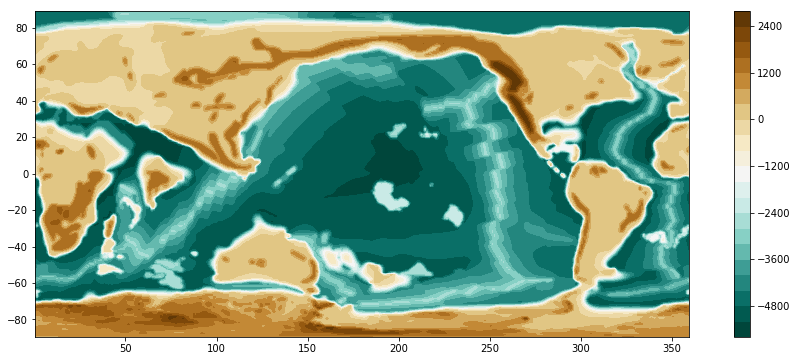

In [2]:
ptopo.plot()


Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...


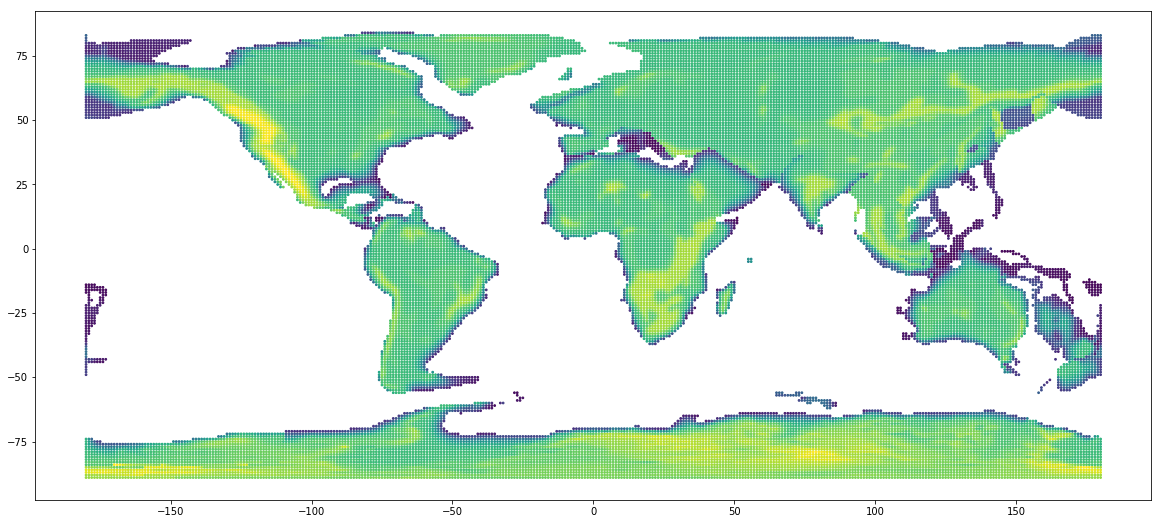

In [3]:
from_time = 55.
to_time = 0.

(unreconstructed_point_lons,
 unreconstructed_point_lats,
 eocene_topography_points) = reconstruct_raster(ptopo, S2012.static_polygons, S2012.rotation_model,
                                                from_time, to_time, 
                                                grid_sampling=1.0)

plt.figure(figsize=(20,9))
plt.scatter(unreconstructed_point_lons,unreconstructed_point_lats,
            c=eocene_topography_points,s=3)
plt.show()


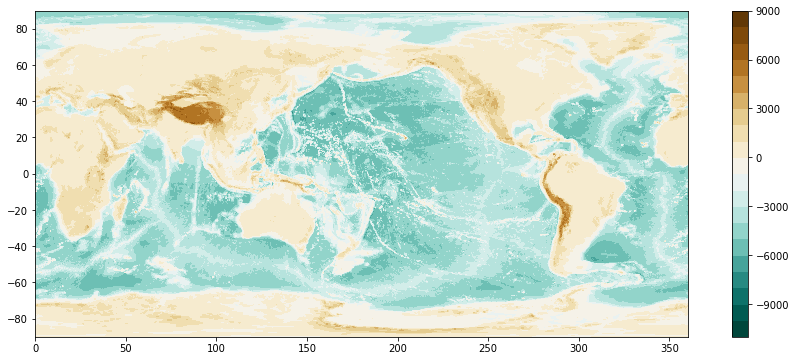

In [4]:
topography = GplatesRaster('../data/ETOPO1_0.1.grd')

topography.plot()


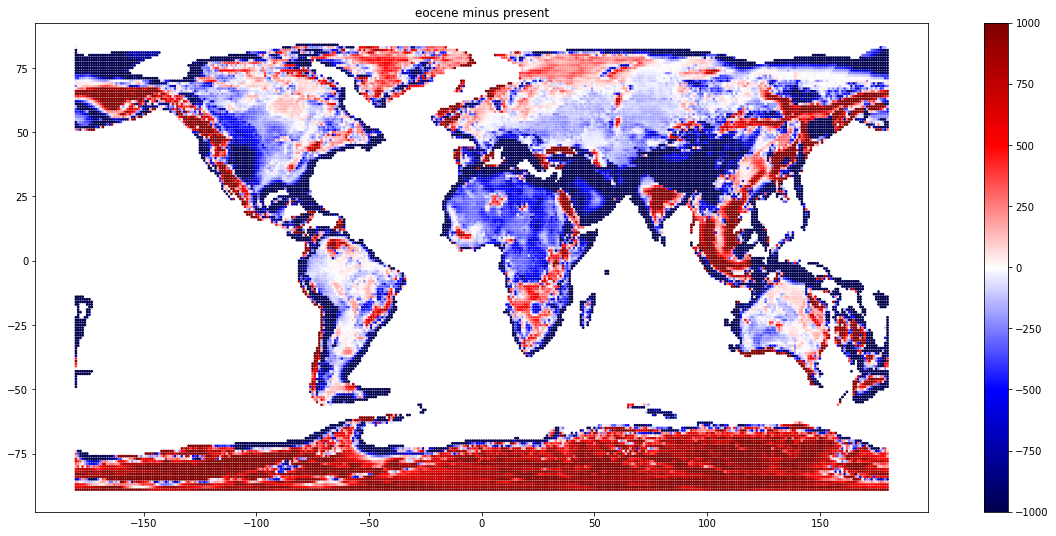

In [5]:
present_day_topography_points = topography.sample_using_gmt(unreconstructed_point_lons,
                                                            unreconstructed_point_lats)

plt.figure(figsize=(20,9))
plt.scatter(unreconstructed_point_lons, unreconstructed_point_lats,
            c=eocene_topography_points-present_day_topography_points, s=3,
            cmap=plt.cm.seismic, vmin=-1000., vmax=1000.)
plt.colorbar()
plt.title('eocene minus present')
plt.show()


Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...


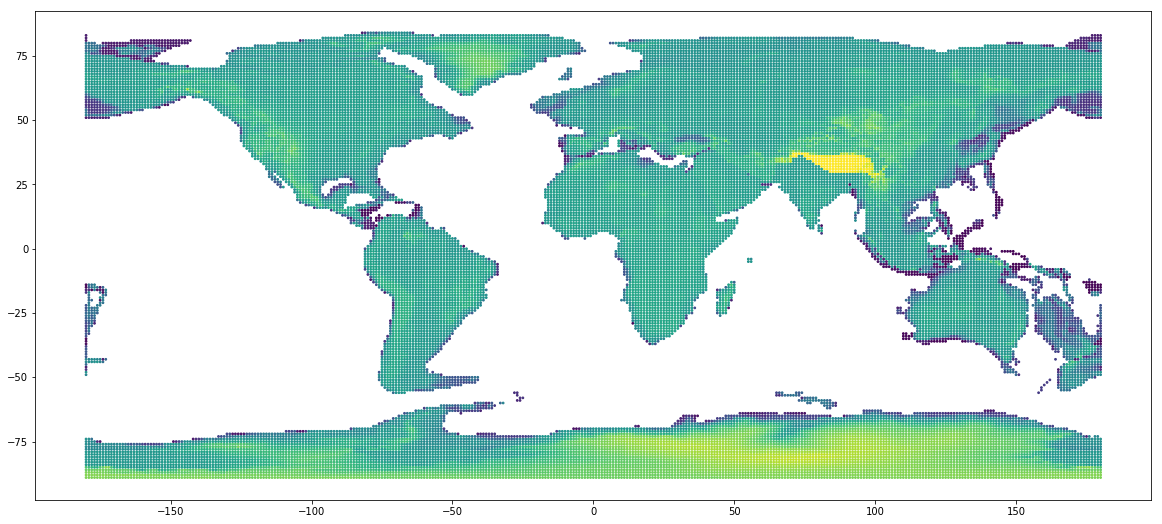

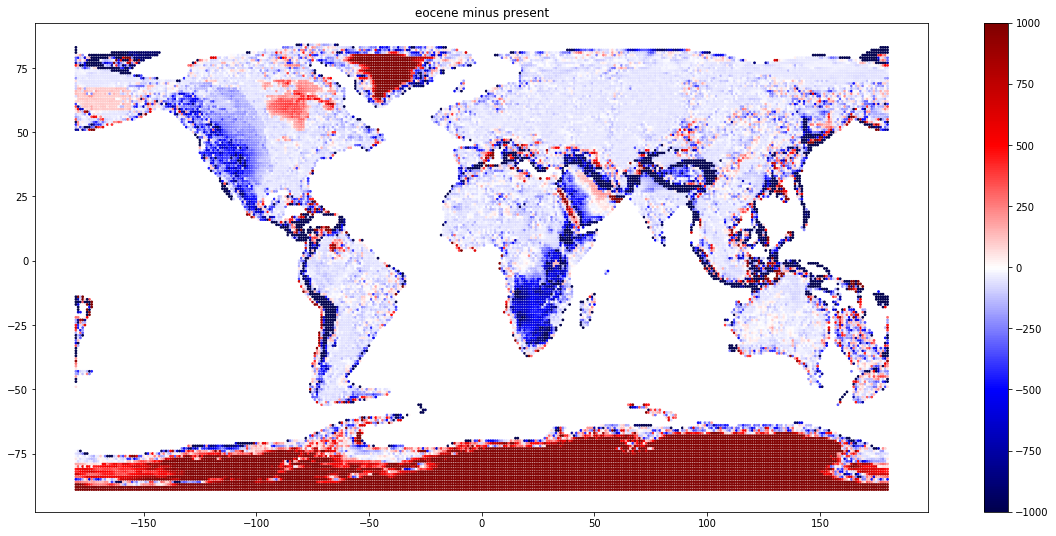

In [6]:
paleotopography_grid = '../published/Herold/topo01_proxy_0.5deg.nc'

ptopo_miocene = GplatesRaster(paleotopography_grid)

from_time = 15.
to_time = 0.

(unreconstructed_point_lons,
 unreconstructed_point_lats,
 miocene_topography_points) = reconstruct_raster(ptopo_miocene, S2012.static_polygons, S2012.rotation_model,
                                                from_time, to_time, 
                                                grid_sampling=1.0)

plt.figure(figsize=(20,9))
plt.scatter(unreconstructed_point_lons,unreconstructed_point_lats,
            c=miocene_topography_points,s=3)
plt.show()

present_day_topography_points = topography.sample_using_gmt(unreconstructed_point_lons,
                                                            unreconstructed_point_lats)

plt.figure(figsize=(20,9))
plt.scatter(unreconstructed_point_lons, unreconstructed_point_lats,
            c=miocene_topography_points-present_day_topography_points, s=3,
            cmap=plt.cm.seismic, vmin=-1000., vmax=1000.)
plt.colorbar()
plt.title('eocene minus present')
plt.show()


[130198 130200 130202 ..., 258756 258758 258760]


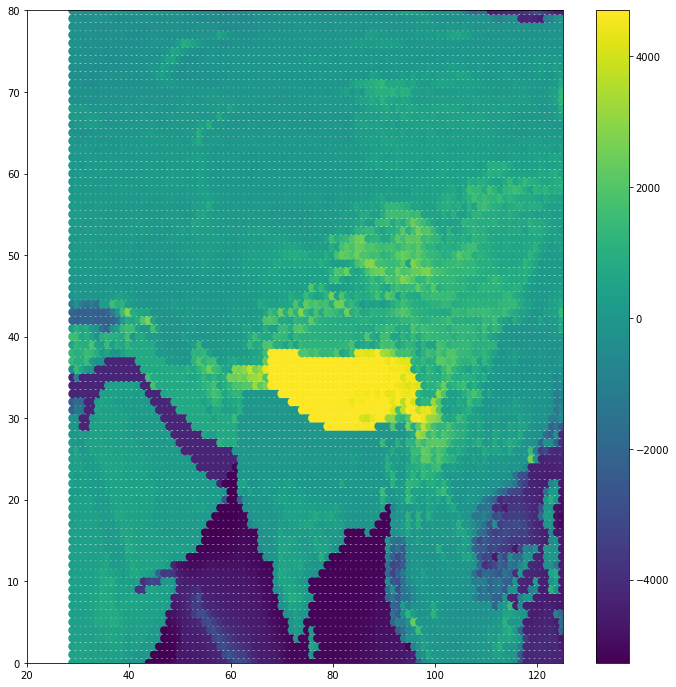

In [7]:
from scipy import spatial

def rtp2xyz(r, theta, phi):
    # if only one value, shape will be empty, hence the next if statement
    if r.size==1:
        rdim=1
    else:
        rdim = r.shape[0]
    rst = r * np.sin(theta)
    xout = np.zeros((rdim,3))
    xout[:,0] = rst * np.cos(phi)       # x
    xout[:,1] = rst * np.sin(phi)       # y
    xout[:,2] = r * np.cos(theta)       # z

    return xout


def create_tree_for_spherical_data(inputLons, inputLats, inputVals, n=16):

    ithetas = np.radians(90.-inputLats)
    iphis   = np.radians(inputLons)
    irs     = np.ones(np.shape(ithetas))
    nodes = []
    
    ixyzs=rtp2xyz(irs.ravel(), ithetas.ravel(), iphis.ravel())
    tree = spatial.cKDTree(ixyzs, n)

    return tree

def sampleOnSphere(inputLons, inputLats, inputVals, sample_points_lons, sample_points_lats, tree=None, n=16, k=1, distance_upper_bound=np.inf):

    # if distance_upper_bound specified, assume that it is specified in degrees, convert to radians
    if not np.isnan(distance_upper_bound):
        distance_upper_bound = np.radians(distance_upper_bound)

    if (tree is None):
        tree = create_tree_for_spherical_data(inputLons, inputLats, inputVals)
    
    othetas = np.radians(90.-sample_points_lats)
    ophis   = np.radians(sample_points_lons)
    oxyzs=rtp2xyz(np.ones(np.shape(othetas)), othetas, ophis)

    d,l = tree.query(oxyzs, k=k, distance_upper_bound=distance_upper_bound)

    return d,l

def sample(gridX, gridY, gridZ, point_lons, point_lats):

        Xg, Yg = np.meshgrid(gridX,gridY)
        d,l = sampleOnSphere(Xg.flatten(),
                             Yg.flatten(), 
                             gridZ.flatten(),
                             np.array(point_lons),
                             np.array(point_lats),
                             k=1)

        #print d,l
        # based on http://earthpy.org/interpolation_between_grids_with_ckdtree.html
        # note also that where d is zero, we get a divide by zero error - hence, these 
        # values are (currently) set to one 
        #w = np.divide(1.,d**2, out=np.ones_like(d), where=d!=0)
        #point_z = np.sum(w * gridZ.flatten().ravel()[l],axis=1) / np.sum(w,axis=1)

        point_z = gridZ.flatten().ravel()[l]
        
        return d,l,point_z

tmpX,tmpY = np.meshgrid(np.arange(29,141.5,1.),np.arange(0,90,1))
    
d,l,zval = sample(ptopo_miocene.gridX,
              ptopo_miocene.gridY,
              ptopo_miocene.gridZ,
              tmpX.flatten(),
              tmpY.flatten())

print l

plt.figure(figsize=(12,12))
plt.scatter(tmpX.flatten(),
            tmpY.flatten(),
            c=zval,s=80, edgecolors='') #,cmap=plt.cm.seismic, vmin=-2000, vmax=2000)
plt.axis([20,125,0,80])
plt.colorbar()
